# Checkpoint 2 - EDA

In [1]:
#import libraries and packages
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import os, numpy, nltk, json, scipy, statistics, matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode
import IPython.display as ipd
from nltk.util import ngrams
#from library import * (we are still working on this, as it is not currently running)

# EDA

In [2]:
#load cleaned dataframe from ETL pipeline 
df = pd.read_pickle('../test/cleaned_data.pkl')

In [3]:
#functions we used for our EDA 
#these functions also exist in our library.py, but currently does not run. 

def frequency_counts(df):
    y_list = df['y'] #ys for every clip
    sr_list = df['sr']
    hop_length = 512
    notes = {'C': [],'C#': [],'D': [],'D#': [],'E': [],'F': [],'F#': [],'G': [],'G#': [],'A': [],'A#': [],'B': []}
    
    #goes through all clips
    for i in range(len(y_list)): 
        chromagram = librosa.feature.chroma_stft(y = y_list[i], sr=sr_list[i], hop_length=hop_length)
        
        notecount = 0 #total number of notes we are getting from clip
        counts = [] #final length should be 12
        
        #goes through each of 12 arrays (notes) in chromagram 
        for note in range(len(chromagram)): 
            count = 0 #count for specific note in clip
            
            #goes through each note array in chromagram 
            for j in chromagram[note]:
                
                #minimum "loudness" that would qualify as a correct note
                if j >=0.9:
                    
                    #add to count of specific note in clip
                    count+=1
                    
                    #add to count of total notes in clip
                    notecount += 1
            counts.append(count)
        
        #going through counts of each note in clip
        for j in range(len(counts)):
            counts[j] = counts[j]/notecount
        
        #going through global note count dictionary
        for n in range(len(notes)):
            note = list(notes)
            #adds each note's frequency in this clip to global dictionary
            notes[note[n]].append(counts[n])
            
    for note in notes:
        #takes average frequency for each note
        notes[note] = np.mean(notes[note])
        
    notedf = pd.DataFrame.from_dict(notes, orient = 'index')
    return notedf

def frequency_plot_generator(df):
    
    histogram_df = frequency_counts(df)

    #generate plots
    plot = histogram_df.sort_values(by=[0])[:7].sort_index().rename(columns={0:'Notes'}).plot(kind = 'bar', title = df['songs'][0])
    plot.set_xlabel("Notes")
    plot.set_ylabel("Frequency")
    
    return histogram_df

def numtonote(num):
    if num == 0:
        return 'C'
    if num == 1:
        return 'C#'
    if num == 2:
        return 'D'
    if num == 3:
        return 'D#'
    if num == 4:
        return 'E'
    if num == 5:
        return 'F'
    if num == 6:
        return 'F#'
    if num == 7:
        return 'G'
    if num == 8:
        return 'G#'
    if num == 9:
        return 'A'
    if num == 10:
        return 'A#'
    if num == 11:
        return 'B'

#bigram/trigram/ngram analysis

def create_ngrams(df):
    
    cleaned_df = df
    
    #gives us df of clip title (raga name), y, sr
    y_list = cleaned_df['y']
    sr_list = cleaned_df['sr']
    
    ragabigrams = {}
    ragatrigrams = {}
    
    for i in range(len(y_list)):
        chromagram = librosa.feature.chroma_stft(y = y_list[i], sr=sr_list[i], hop_length=512)
        if i == 2: 
            plt.figure(figsize=(17, 5))
            plt.title('Chromagram for Raga '+ cleaned_df['songs'][0])
            librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')
            
        #helper function return
        bigramdict = extract_ngrams(chromagram,2)
        for key in bigramdict:
            if key in ragabigrams:
                ragabigrams[key] += bigramdict[key]
                
            else:
                ragabigrams[key] = bigramdict[key]
                
                bigramdict = extract_ngrams(chromagram,2)
        
        trigramdict = extract_ngrams(chromagram,3)
        for key in trigramdict:
            if key in ragatrigrams:
                ragatrigrams[key] += trigramdict[key]
                
            else:
                ragatrigrams[key] = trigramdict[key]
    
    bdf = pd.DataFrame({'Bigrams': list(ragabigrams.keys()), 'Counts': list(ragabigrams.values())})
    plot = bdf.sort_values(by = 'Counts', ascending = False)[:10].plot(kind = 'bar', x= 'Bigrams', y = 'Counts', title = cleaned_df['songs'][0]) 
    plot.set_xlabel("Bigrams")
    plot.set_ylabel("Counts")
    
    tdf = pd.DataFrame({'Trigrams': list(ragatrigrams.keys()), 'Counts': list(ragatrigrams.values())})
    plot2 = tdf.sort_values(by = 'Counts', ascending = False)[:10].plot(kind = 'bar', x= 'Trigrams', y = 'Counts', title = cleaned_df['songs'][0]) 
    plot2.set_xlabel("Trigrams")
    plot2.set_ylabel("Counts")
    
    return None


def extract_ngrams(chromagram, num):
    seq_notes = []
    max_val = []
    for row in chromagram.T:
        seq_notes.append(np.argmax(row))
        max_val.append(np.max(row))
    all_notes = pd.Series(seq_notes).apply(numtonote)

    values = []
    for i in range(0, len(all_notes),22):
        curr = all_notes[i:i+22]
        values.append(mode(curr)[0][0])

    newvals = []
    for i in range(len(values)):
        if i != 0 and values[i] == values[i-1]:
            continue
        else:
            newvals.append(values[i])
        
    n_grams = ngrams(newvals, num)
    fdist = nltk.FreqDist(n_grams)
    ngramlist = []
    counts = []
    for k,v in fdist.items():
        ngramlist.append(k)
        counts.append(v)
    clipdict = {ngramlist[i]: counts[i] for i in range(len(ngramlist))}

    return clipdict


In [4]:
#names of ragas to be analyzed 
ragas = list(df['songs'].unique())
ragas

['Todi Subhapantuvarali', 'Asavari Natabhairavi']

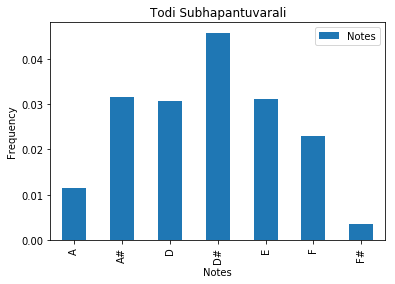

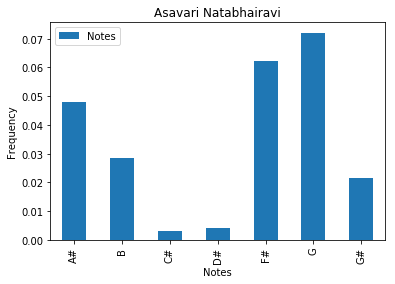

In [5]:
#creates frequency plots
for raag in ragas: 
    frequency_plot_generator(df[df['songs'] == raag].reset_index())

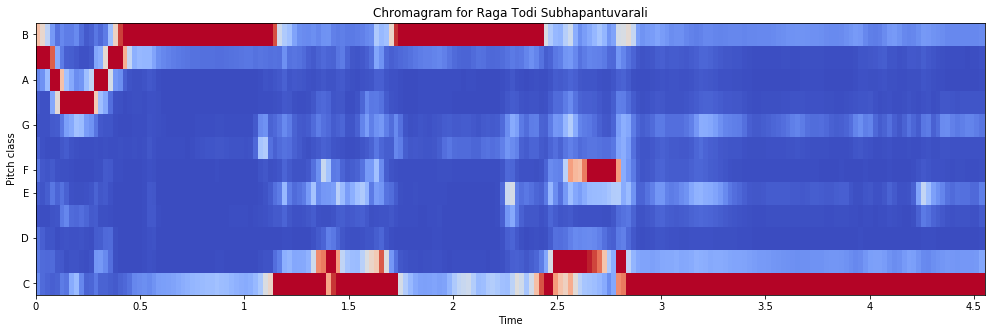

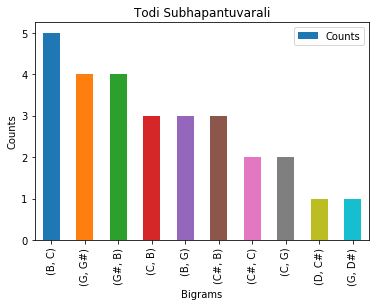

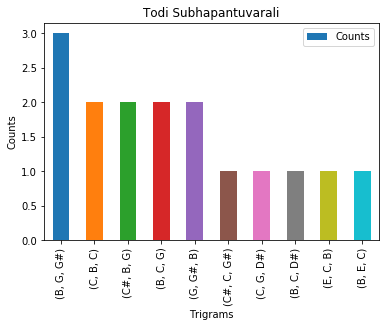

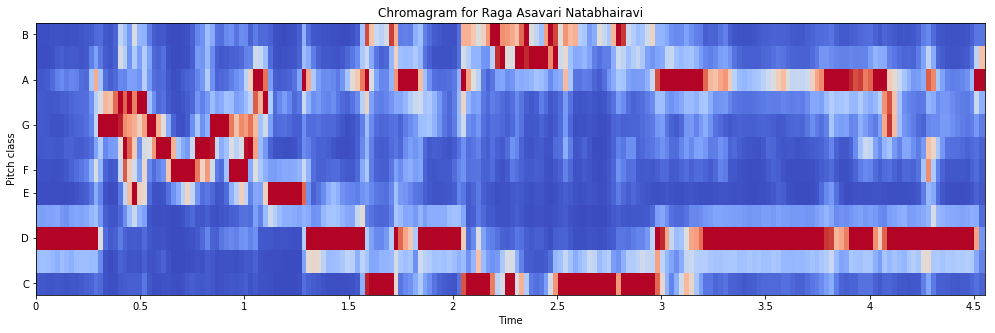

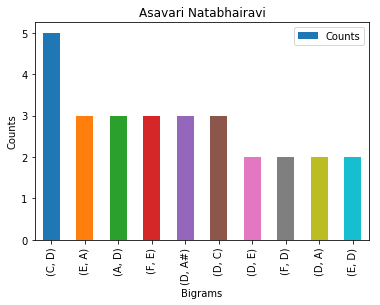

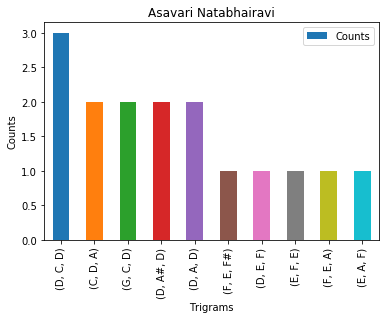

In [6]:
#creates chromagram/bigram/trigram for the raga
for raag in ragas: 
    create_ngrams(df[df['songs'] == raag].reset_index())